In [1]:
import sys
sys.path.append('./QCNN_inference_pyc.zip')
from QCNN_inference import qcnn_circuit, load_breastmnist_data

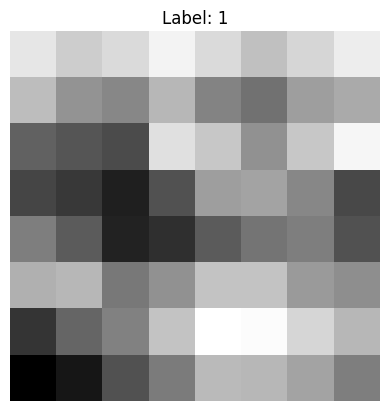

In [2]:
# Load a small sample of BreastMNIST images (resized to 8×8)
# Fetches 10 training and 10 test images
x_train, y_train, x_test, y_test = load_breastmnist_data(num_train=10, num_test=10)

# Select a single example for visualization and encoding
features_sample = x_train[0]
label = y_train[0]

# Show the original image
import matplotlib.pyplot as plt
plt.imshow(features_sample.reshape(8, 8), cmap="gray")
#plt.imshow(features_sample.reshape(8, 8))
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit.circuit.library import XGate
from qiskit_aer import AerSimulator
from qiskit.compiler import transpile

def encoder_neqr(features, color_bits=8):
    """
    NEQR encoder - stores color as binary values in separate qubits
    For 2^n x 2^n image: total qubits = 2n (position) + color_bits (color)
    """
    num_pixels = len(features)
    num_pos_qubits = int(np.ceil(np.log2(num_pixels)))
    num_qubits = num_pos_qubits + color_bits
    
    qc = QuantumCircuit(num_qubits)
    
    # Qubit indices
    color_qubits = list(range(color_bits))  # First 'color_bits' qubits for color
    position_qubits = list(range(color_bits, num_qubits))  # Remaining for position
    
    # Initialize superposition for positions
    qc.h(position_qubits)
    
    # Encode each pixel
    for i, pixel_value in enumerate(features):
        if pixel_value == 0:
            continue
            
        # Convert pixel value to binary
        binary_repr = format(pixel_value, f'0{color_bits}b')
        
        # Set control state for this position
        control_state = format(i, f'0{num_pos_qubits}b')
        
        # Add X gates for control state (0->X, 1->no gate)
        for j, bit in enumerate(reversed(control_state)):
            if bit == '0':
                qc.x(position_qubits[j])
        
        # Encode color bits using controlled-X gates
        for color_idx, bit in enumerate(reversed(binary_repr)):
            if bit == '1':
                # Multi-controlled X gate to set this color qubit to |1⟩
                control_qubits = position_qubits  # Control on position
                target_qubit = color_qubits[color_idx]
                
                # Create multi-controlled X gate
                mc_x = XGate().control(num_pos_qubits)
                qc.append(mc_x, control_qubits + [target_qubit])
        
        # Uncompute control state
        for j, bit in enumerate(reversed(control_state)):
            if bit == '0':
                qc.x(position_qubits[j])
    
    return qc, num_pos_qubits, color_bits



In [4]:
def decode_neqr(neqr_circuit, num_pos_qubits, color_bits, num_shots=1024):
    """
    Corrected NEQR decoder that respects LSB-first encoding used by the encoder.
    Aggregates measurements by weighted averaging (shots).
    """
    
    num_qubits = neqr_circuit.num_qubits
    num_pixels = 2 ** num_pos_qubits

    # Build measured circuit
    measured = QuantumCircuit(num_qubits, num_qubits)
    measured.compose(neqr_circuit, range(num_qubits), inplace=True)
    measured.measure(range(num_qubits), range(num_qubits))

    sim = AerSimulator()
    transpiled = transpile(measured, sim)
    result = sim.run(transpiled, shots=num_shots).result()
    counts = result.get_counts()

    # Accumulators
    color_sums = np.zeros(num_pixels, dtype=float)
    shot_counts = np.zeros(num_pixels, dtype=int)

    for bitstring, cnt in counts.items():
        # Make string indexed by qubit index: all_bits[i] is qubit i
        all_bits = bitstring[::-1]

        # color and position slices (LSB-first because encoder used reversed(...))
        color_bits_str_lsb_first = all_bits[:color_bits]
        pos_bits_str_lsb_first = all_bits[color_bits:color_bits + num_pos_qubits]
        


        # Convert to integers: reverse substring to MSB-first before int(...)
        color_value = int(color_bits_str_lsb_first[::-1], 2) if color_bits > 0 else 0
        position = int(pos_bits_str_lsb_first[::-1], 2) if num_pos_qubits > 0 else 0

        if position < num_pixels:
            color_sums[position] += color_value * cnt
            shot_counts[position] += cnt

    # Compute weighted average (or 0 if never observed)
    reconstructed = np.zeros(num_pixels, dtype=np.uint8)
    for i in range(num_pixels):
        if shot_counts[i] > 0:
            reconstructed[i] = int(round(color_sums[i] / shot_counts[i]))
        else:
            reconstructed[i] = 0

    return reconstructed


In [8]:
# MedMNIST for the dataset
from PIL import Image
import medmnist
from medmnist import BreastMNIST

print("Loading BreastMNIST dataset...")
train_dataset = BreastMNIST(split="train", download=True)

# Select an image (e.g., the 10th image in the dataset)
IMAGE_INDEX = 10
pil_image, label = train_dataset[IMAGE_INDEX]

# Pre-process the image for FRQI
TARGET_SIZE = (8, 8) # 8x8 = 64 pixels = 2^6 pixels
image_resized = pil_image.resize(TARGET_SIZE, Image.Resampling.LANCZOS)
image_np = np.array(image_resized)
features = image_np.flatten() # Flatten the 2D image to a 1D vector

print(f"Encoding the {TARGET_SIZE[0]}x{TARGET_SIZE[1]} image...")
neqr_circuit, num_pos_qubits, color_bits = encoder_neqr(features)
print(f"NEQR circuit created with {neqr_circuit.num_qubits} qubits.")
print(f"Color bits: {color_bits}")


reconstructed_1024 = decode_neqr(neqr_circuit, num_pos_qubits, color_bits,  num_shots=1024)
image_1024 = reconstructed_1024.reshape(TARGET_SIZE)


reconstructed_8192 = decode_neqr(neqr_circuit, num_pos_qubits, color_bits,  num_shots=8192)
image_8192 = reconstructed_8192.reshape(TARGET_SIZE)




Loading BreastMNIST dataset...
Encoding the 8x8 image...
NEQR circuit created with 14 qubits.
Color bits: 8


(np.float64(-0.5), np.float64(7.5), np.float64(7.5), np.float64(-0.5))

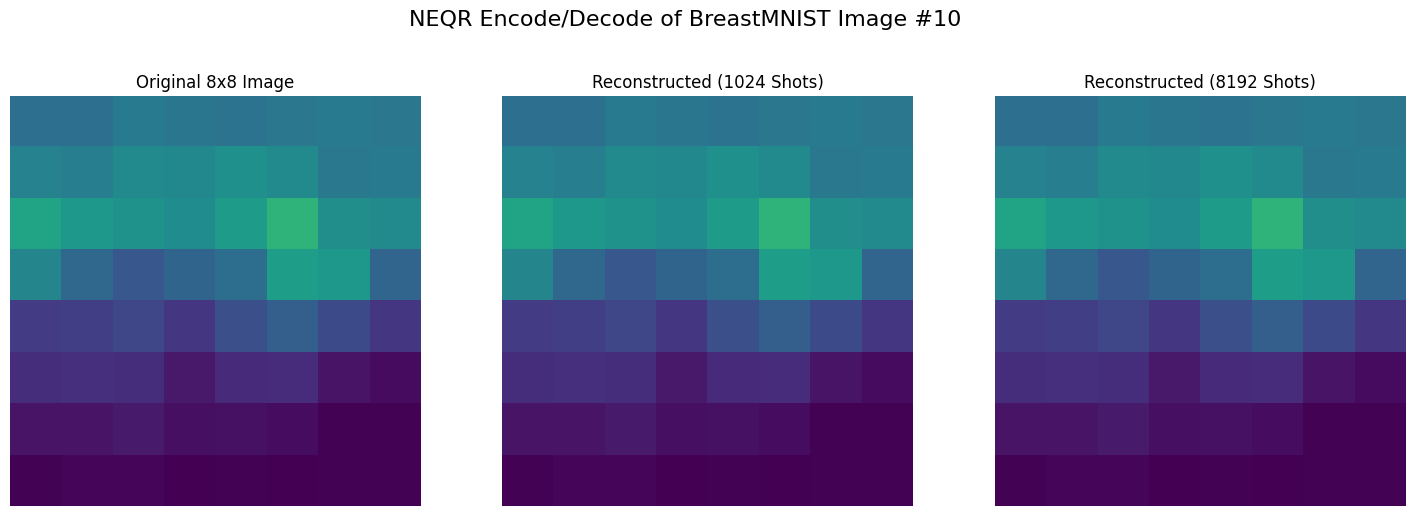

In [9]:

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f'NEQR Encode/Decode of BreastMNIST Image #{IMAGE_INDEX}', fontsize=16)

axes[0].imshow(image_np, vmin=0, vmax=255)
axes[0].set_title(f"Original {TARGET_SIZE[0]}x{TARGET_SIZE[1]} Image")
axes[0].axis('off')

axes[1].imshow(image_1024, vmin=0, vmax=255)
axes[1].set_title("Reconstructed (1024 Shots)")
axes[1].axis('off')

axes[2].imshow(image_8192, vmin=0, vmax=255)
axes[2].set_title("Reconstructed (8192 Shots)")
axes[2].axis('off')
